# Exercise week 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Task 1: Bayesian Regression

A

In [2]:
points = pd.read_csv("points.txt", header=None, delim_whitespace=True)
points

,0,1
0,-1.00,-0.72
1,-0.21,-0.21
2,-0.12,0.01
3,0.05,0.10
4,0.17,0.20
5,0.22,0.28
6,0.35,0.39
7,0.51,0.51
8,0.55,0.59
9,0.62,1.00


In [3]:
# Shuffle data in case of non-random order
shuffled_points = points.sample(frac=1)

# Define target and feature arrays
X = shuffled_points.iloc[:, 0].to_numpy()
y = shuffled_points.iloc[:, 1].to_numpy()

# Find split index
split_idx = int(0.5 * len(shuffled_points))

# Split into train and test sets
X_train = X[:split_idx]
y_train = y[:split_idx]
X_test = X[split_idx:]
y_test = y[split_idx:]

In [4]:
# Define hyperparameters
alpha = 2
beta = 25

# Form design matrix
X_train_dsn = np.column_stack((np.ones_like(X_train), X_train))
X_test_dsn = np.column_stack((np.ones_like(X_test), X_test))

# Compute posterior parameters
alpha_matrix = alpha * np.identity(X_train_dsn.shape[1]) # priors
beta_matrix = beta * (X_train_dsn.T @ X_train_dsn)
S_N = np.linalg.inv(alpha_matrix + beta_matrix) # covariance matrix (Sigma_N)
mu_N = beta * (S_N @ X_train_dsn.T) @ y_train # posterior mean

# Sample from the posterior to estimate w0 and w1
w_samples = np.random.multivariate_normal(mu_N.ravel(), S_N, 1).T
w0_hat, w1_hat = w_samples

print(f"w0_hat: {w0_hat[0]}\nw1_hat: {w1_hat[0]}")

w0_hat: 0.11760005721714789
w1_hat: 0.9746513668616522


B

In [6]:
# List of lines
lines = []

# Sample lines
for i in range(10):
    temp_w_samples = np.random.multivariate_normal(mu_N.ravel(), S_N, 1).T
    temp_20_hat, temp_w1_hat = temp_w_samples
    
    # Create the estimated lines using sampled w0 and w1
    est_line = X_train * temp_w1_hat + temp_20_hat
    lines.append(est_line)

# Average line
avg_line = np.mean(np.vstack(lines), axis=0)
avg_line

array([-0.6658529 ,  0.15563175, -0.28893642,  0.60019991,  0.31992868,
       -0.85914341, -0.05698781, -0.21162021,  0.27160605,  0.70650969])

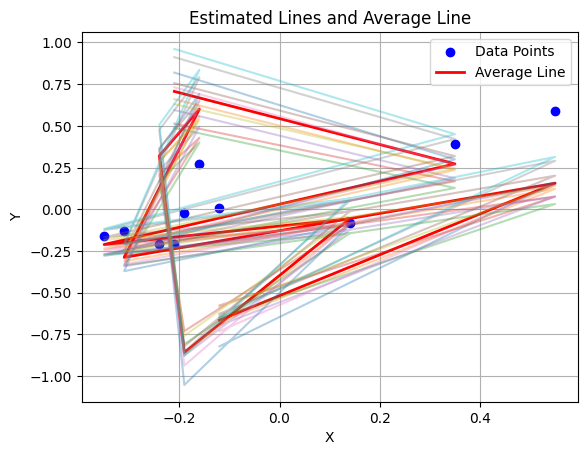

In [16]:
# Plot the data points
plt.scatter(X_test, y_test, label='Data Points', color='b')

# Plot the estimated average line
plt.plot(X_test, avg_line, label='Average Line', color='r', linewidth=2)

# Plot the 10 different lines
for i in range(10):
    plt.plot(X_test, lines[i], label=f'Line {i}', alpha=0.35)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Data Points', 'Average Line'])
plt.title('Estimated Lines and Average Line')
plt.grid(True)
plt.show()

C

In [6]:
# Estimate on training data
y_train_pred = w0_hat + w1_hat*X_train
y_train_pred

array([-0.79015164, -0.01772914, -0.09672689, -0.05283925, -0.27227746,
        0.53525515, -0.21961229, -0.12305948, -0.06161678,  0.2104866 ])

D

In [7]:
# Predict on test data
y_test_pred = w0_hat + w1_hat*X_test

# RMSE
def rmse(target, pred):
    return np.sqrt(np.mean((pred - target)**2)).round(3)

rmse_train = rmse(y_train, y_train_pred)
rmse_test = rmse(y_test, y_test_pred)

print(f"Train set RMSE: {rmse_train}\nTest set RMSE: {rmse_test}")

Train set RMSE: 0.152
Test set RMSE: 0.138


## Task 2: Bayesian Predictive Distribution

A

In [3]:
# Generate X from uniform distribution between 0 and 1
X = np.random.uniform(0, 1, 1000)

# Generate noise
chi = np.random.normal(0, 0.3**2, 1000) # mean 0, std 0.3**2

# Compute targets and add noise
t = np.sin(2 * np.pi * X) + chi

B

In [4]:
# Define the parameters
bas_func = 9
mu_values = np.linspace(0, 1, bas_func) # Centres of gaussian radial basis functions
s = 0.1 # scale (width of basis functions)

# Initialize the design matrix Phi^T with zeros
Phi_T = np.zeros((bas_func, len(X)))

# Compute the value of each basis function for each data point
for j in range(bas_func):
    phi_j = np.exp(-((X - mu_values[j]) ** 2) / (2 * s ** 2))
    Phi_T[j, :] = phi_j

# Add bias
bias = np.ones((1, len(X)))
Phi_T = np.vstack((bias, Phi_T))

C

In [5]:
# Define hyperparameters
alpha = 0.5
beta = 10

# Compute posterior parameters
alpha_matrix = alpha * np.identity(10) # priors with shape of design matrix
beta_matrix = beta * (Phi_T @ Phi_T.T)
S_N = np.linalg.inv(alpha_matrix + beta_matrix) # covariance matrix (Sigma_N)
m_N = beta * (S_N @ Phi_T @ t) # posterior mean

In [6]:
def pred_mean(x, design_matrix, posterior_mean):
    # design matrix (radial basis functions) of given x
    phi_x = np.array([np.exp(-(x - mu)**2 / (2 * s**2)) for mu in mu_values])
    phi_x = np.insert(phi_x, 0, 1)  # Add bias

    # Compute predictive mean (dot product of m_N and design matrix for given x)
    y_x = posterior_mean @ phi_x

    return y_x

def predictive_std(x, design_matrix, Sigma_N):
    # design matrix (radial basis functions) of given x
    phi_x = np.array([np.exp(-(x - mu)**2 / (2 * s**2)) for mu in mu_values])
    phi_x = np.insert(phi_x, 0, 1)  # Add bias

    # Compute predictive std
    sigma_N_x = np.sqrt(1 / (1 / (0.3**2) + (phi_x @ Sigma_N) @ phi_x.T))
    
    return sigma_N_x

In [32]:
pred_mean(1, Phi_T, m_N)

-0.08819284522559051

In [33]:
predictive_std(1, Phi_T, S_N)

0.2999443482667594

D

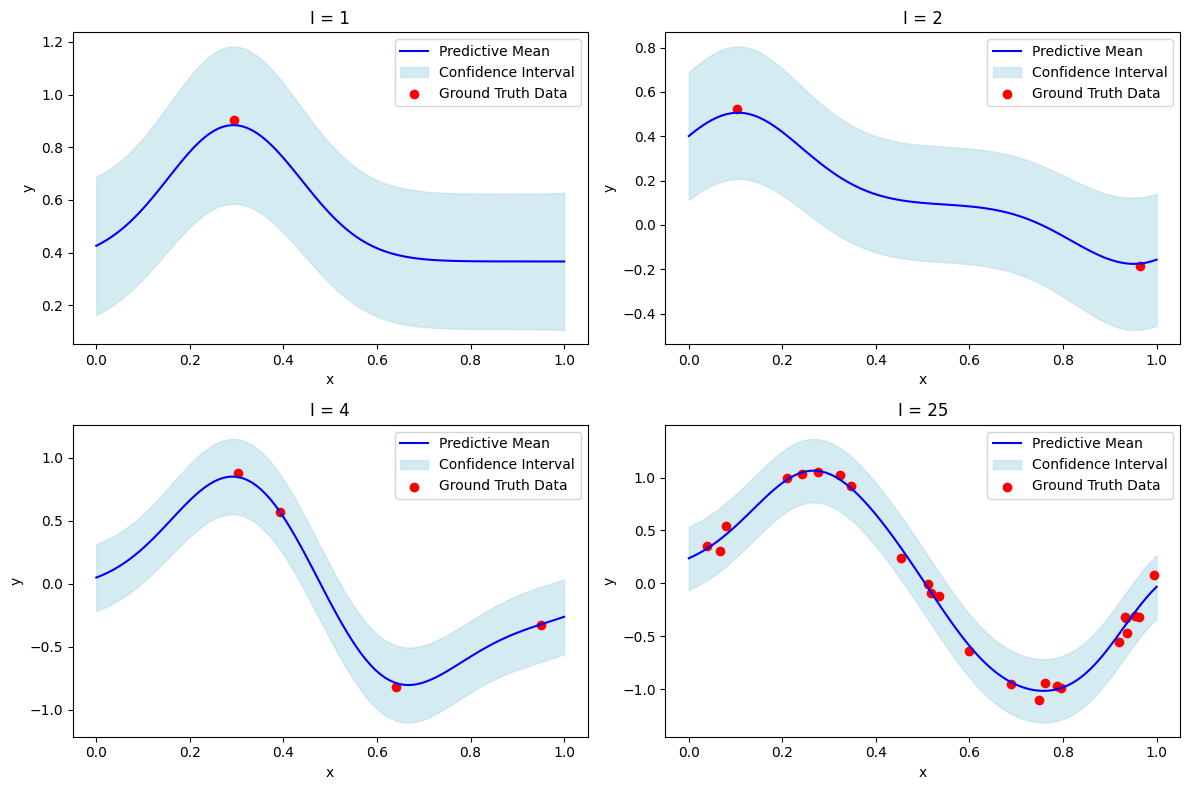

In [26]:
# Define a range of x values for plotting
x_range = np.linspace(0, 1, 100)

# Values of I to plot
I_values = [1, 2, 4, 25]

# Plot the predictive mean, confidence intervals, and ground truth for each I
plt.figure(figsize=(12, 8))

for i, I in enumerate(I_values):
    plt.subplot(2, 2, i + 1)
    plt.title(f'I = {I}')
    
    # Generate I random data points
    X_i = np.random.uniform(0, 1, I)
    t_i = np.sin(2 * np.pi * X_i) + np.random.normal(0, 0.3**2, I)
    
    # Compute posterior parameters
    Phi_T_i = np.zeros((bas_func, I))
    for j in range(bas_func):
        phi_j = np.exp(-((X_i - mu_values[j]) ** 2) / (2 * s ** 2))
        Phi_T_i[j, :] = phi_j
    
    # Add bias
    bias = np.ones((1, Phi_T_i.shape[1]))
    Phi_T_i = np.vstack((bias, Phi_T_i))

    alpha_matrix_i = alpha * np.identity(bas_func + 1)
    beta_matrix_i = beta * (Phi_T_i @ Phi_T_i.T)
    S_N_i = np.linalg.inv(alpha_matrix_i + beta_matrix_i) # covariance matrix
    m_N_i = beta * (S_N_i @ Phi_T_i @ t_i) # posterior mean
    
    # Compute predictive mean and standard deviation for the x_range
    y_pred_values = []
    sigma_pred_values = []
    for x in x_range:
        y_pred =  pred_mean(x, Phi_T_i, m_N_i)
        sigma_pred = predictive_std(x, Phi_T_i, S_N_i)
        y_pred_values.append(y_pred)
        sigma_pred_values.append(sigma_pred)
    
    # Convert to numpy arrays
    y_pred_values = np.array(y_pred_values)
    sigma_pred_values = np.array(sigma_pred_values)
    
    # Plot the predictive mean
    plt.plot(x_range, y_pred_values, label='Predictive Mean', color='blue')
    
    # Plot confidence intervals (±1 standard deviation)
    plt.fill_between(x_range, y_pred_values - sigma_pred_values, y_pred_values + sigma_pred_values, color='lightblue', alpha=0.5, label='Confidence Interval')
    
    # Plot ground truth data points
    plt.scatter(X_i, t_i, color='red', marker='o', label='Ground Truth Data')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

plt.tight_layout()
plt.show()

## Task 3: Classification

In [9]:
iris = pd.read_csv('iris.csv', names=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species'])
iris

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [10]:
iris.columns

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')

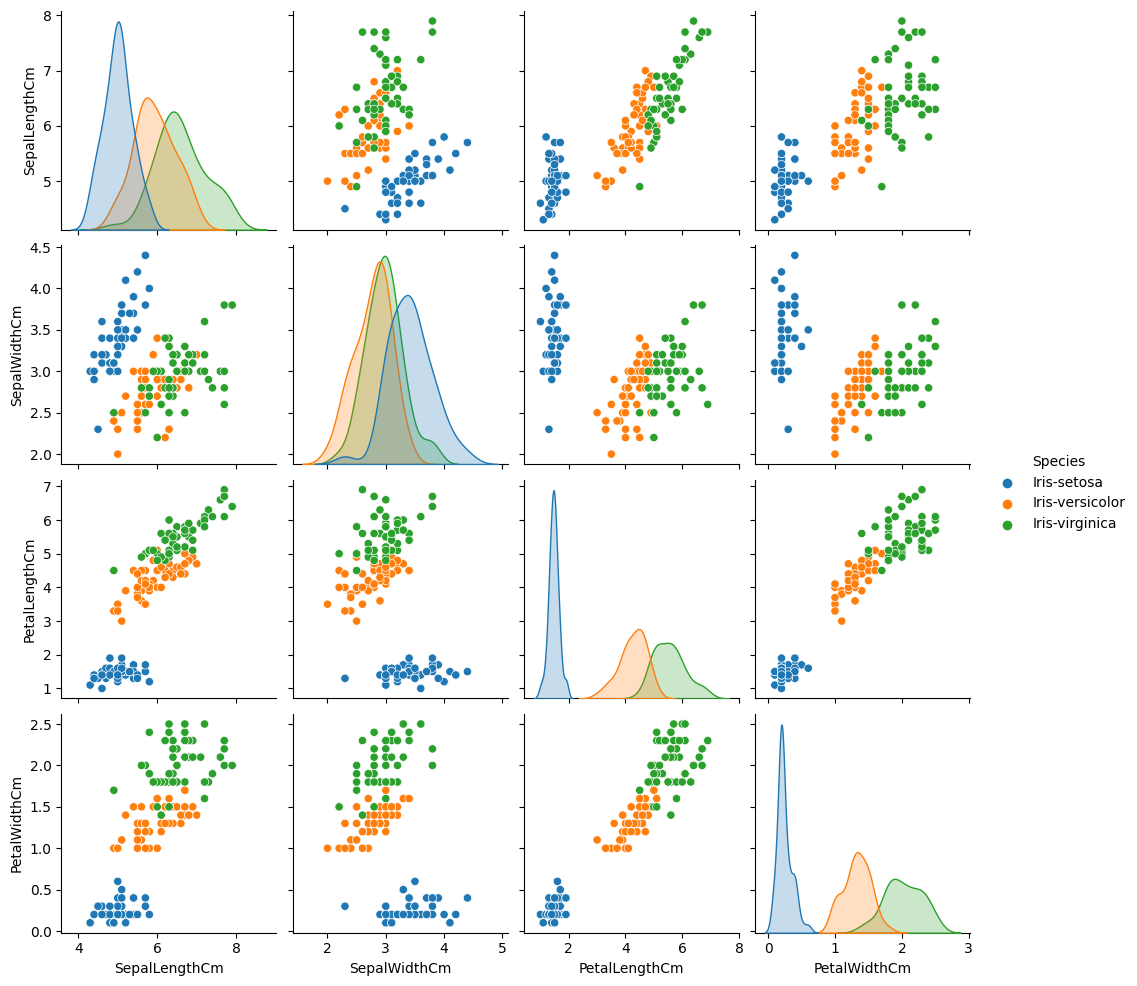

In [12]:
sns.pairplot(iris, hue='Species')

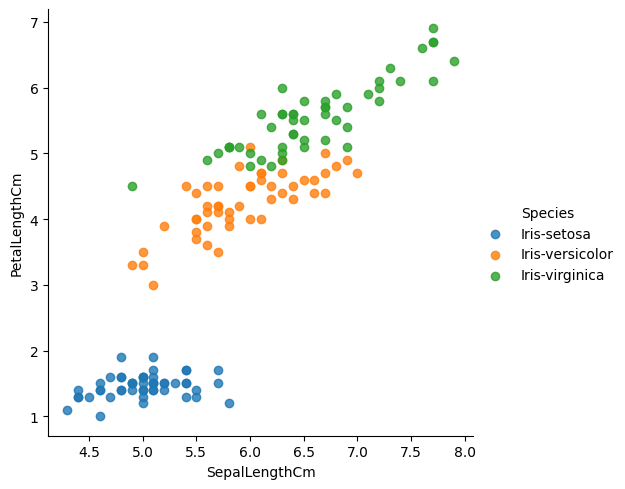

In [17]:
sns.lmplot(iris, x='SepalLengthCm', y='PetalLengthCm', hue='Species', fit_reg=False)

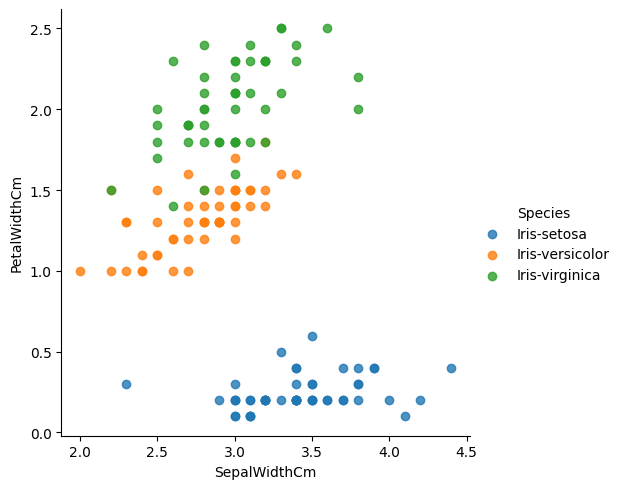

In [18]:
sns.lmplot(iris, x='SepalWidthCm', y='PetalWidthCm', hue='Species', fit_reg=False)

B

In [13]:
# Arrays of each class
setosa = iris.iloc[:50, :4].to_numpy()
versicolor = iris.iloc[50:100, :4].to_numpy()
virginica = iris.iloc[100:, :4].to_numpy()

In [14]:
# Calculate sample means
m_setosa = np.mean(setosa, axis=0)
m_versicolor = np.mean(versicolor, axis=0)
m_virginica = np.mean(virginica, axis=0)

C

In [15]:
# Covariance function
def cov_mat(array):
    Sig_mat = np.zeros((array.shape[1], array.shape[1])) # Initialize matrix
    for x in array:
        d = x - np.mean(array, axis=0) # difference between x and mean
        Sig_mat = Sig_mat + (d * d.T)
        Sig_mat = Sig_mat / len(array)
    return Sig_mat

In [16]:
# Compute sample covariance matrices
S_setosa = cov_mat(setosa)
S_versicolor = cov_mat(versicolor)
S_virginica = cov_mat(virginica)

D

In [17]:
# Joint covariance matrix
Sigma = np.zeros((4, 4)) # initialize matrix

# Loop over classes
for c in [S_setosa, S_versicolor, S_virginica]:
    c_weighted = (50 / 150) * c # weighted class covariance matrix
    Sigma += c_weighted # add to joint covariance matirx

E

In [18]:
def disc_func(x):
    # Sample mean
    sample_mean = np.mean(x, axis=0)
    
    # Compute weights
    w = np.linalg.pinv(Sigma) @ sample_mean

    # Compute intercept
    w0 = 0.5 * (sample_mean.T @ np.linalg.pinv(Sigma) @ sample_mean) + np.log(50/150)

    return w, w0


In [19]:
# Weight and intercepts for each class
w_setosa, w0_setosa = disc_func(setosa)
w_versicolor, w0_versicolor = disc_func(versicolor)
w_virginica, w0_virginica = disc_func(virginica)

In [20]:
# Functions to score each class
def score_setosa(x):
    return w_setosa.T @ x + w0_setosa

def score_versicolor(x):
    return w_versicolor.T @ x + w0_versicolor

def score_virginica(x):
    return w_virginica.T @ x + w0_virginica

F

In [86]:
# Draw two new samples per class from a 4D Gaussian distribution
samples = []

samples.append(np.random.multivariate_normal(m_setosa, S_setosa, 2)) # Setosa samples
samples.append(np.random.multivariate_normal(m_versicolor, S_versicolor, 2)) # versicolor samples
samples.append(np.random.multivariate_normal(m_virginica, S_virginica, 2)) # virginica samples

samples = np.concatenate(samples, axis=0) # Collect in one array

C:\Users\frbre\AppData\Local\Temp\ipykernel_18888\1237618234.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  samples.append(np.random.multivariate_normal(m_setosa, S_setosa, 2)) # Setosa samples
C:\Users\frbre\AppData\Local\Temp\ipykernel_18888\1237618234.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  samples.append(np.random.multivariate_normal(m_versicolor, S_versicolor, 2)) # versicolor samples
C:\Users\frbre\AppData\Local\Temp\ipykernel_18888\1237618234.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  samples.append(np.random.multivariate_normal(m_virginica, S_virginica, 2)) # virginica samples


In [94]:
# Construct df for nice views
sample_df = pd.DataFrame(samples)
sample_df['label'] = [1, 1, 2, 2, 3, 3]
sample_df

,0,1,2,3,label
0,5.001511,3.379912,1.453889,0.239156,1
1,5.004480,3.405099,1.460575,0.242359,1
2,5.933199,2.769905,4.257696,1.325932,2
3,5.998304,2.772114,4.311266,1.327518,2
4,6.450072,2.972753,5.492696,2.010776,3
5,6.416641,2.972450,5.478321,2.007086,3


G

In [105]:
for i, sample in enumerate(samples):
    a = score_setosa(sample)
    b = score_versicolor(sample)
    c = score_virginica(sample)
    sample_df.loc[i, 'pred'] = np.argmax([a, b, c])

In [106]:
sample_df

,0,1,2,3,label,pred
0,5.001511,3.379912,1.453889,0.239156,1,2.0
1,5.004480,3.405099,1.460575,0.242359,1,2.0
2,5.933199,2.769905,4.257696,1.325932,2,2.0
3,5.998304,2.772114,4.311266,1.327518,2,2.0
4,6.450072,2.972753,5.492696,2.010776,3,2.0
5,6.416641,2.972450,5.478321,2.007086,3,2.0


Everything is classified as class 2 (versicolor)??

## Task 4: Theory

Because accuracy is the ratio of correct classifications, achieving a 95% accuracy even though class 2 is always classified as class 1 is possible if the dataset is very unbalanced so that 95% of the samples are labelled as class 1 and only 5% are labelled as class 2. This division would mean that always classifying a sample as class 1 gives you a 95% accuracy.

In many cases, recall (sensitivity) would be a better metric - if for instance, we care mostly about capturing all instances of class 2 but are less worried about mislabelling some actual class 1 samples.

On the other hand, if we really want to make sure that we don't mislabel any class one samples, we might care more about precision which measures how many of the predicted positives were actually positive.

If we want a model that performs well in classifying both class 1 and 2, we can use the F1 score which gives equal weight to recall and precision.

Finally, ROC-AUC is resistant to class imbalance, measuring the model's performance across probability thresholds. It does so by measuring the area under the curve when plotting the false positive rate on the X-axis and true positive rate on the Y-axis.

Similarly, the AUC-PR (area under the precision-recall curve) is very useful when the positive class is uncommon and gives good insight into the tradeoff between precision and recall.